In [1]:
%cd ..

/home/dawood/Workspace/training/face-keypoints


In [2]:
import torch
import cv2
from PIL import Image
from torchvision.transforms import functional as T

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

from models.hrfpn34 import HRFPN34 as Model

norm_mean = [0.485, 0.456, 0.406]
norm_std  = [0.229, 0.224, 0.225]

normalize = lambda x : T.normalize(x, norm_mean, norm_std)

In [10]:
model = Model(69)
model.load_state_dict(torch.load('/home/dawood/Experiments/face-keypoint1eb94ec5e3194e7cb18e20b0addfb9a2/model_4.weights',  map_location="cpu")['state_dict'])
model = model.eval()
#model = model.cuda()

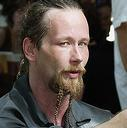

In [11]:
img = Image.open('/home/dawood/Dataset/LS3D-W/Menpo-3D/aflw__face_39840.jpg')
img

In [12]:
inp = T.resize(img, 256)
pred = model(normalize(T.to_tensor(inp)).unsqueeze(0))[-1][0]
pred.shape, T.to_tensor(inp).shape

(torch.Size([69, 65, 64]), torch.Size([3, 258, 256]))

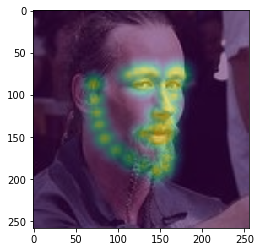

In [13]:
plt.imshow(inp)
plt.imshow(cv2.resize(pred.detach().cpu().numpy()[:68].max(0), inp.size), alpha=0.5)

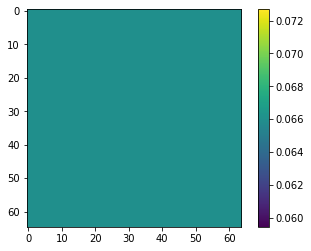

In [15]:
plt.imshow(pred.detach().cpu().numpy()[68])
plt.colorbar()

In [10]:
import numpy as np
import math

from scipy.ndimage.filters import gaussian_filter

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [11]:
def hm2kpts(heatmap, jointmap, hm_threshold=0.1, jm_threshold=0.1, mid_num = 100):
    skeleton = [[16, 14], [14, 12], [17, 15], [15, 13], [12, 13], [6, 12], 
                [7, 13], [6, 7], [6, 8], [7, 9], [8, 10], [9, 11], [2, 3], 
                [1, 2], [1, 3], [2, 4], [3, 5], [4, 6], [5, 7]]
    
    origImg = img.permute(1,2,0).contiguous().numpy()
    
    all_peaks = []
    connection_all = []
    special_k = []
    peak_counter = 0

    for part in range(17):
        map_ori = heatmap[part, :,:]
        map = gaussian_filter(map_ori, sigma=1)

        map_left = np.zeros(map.shape)
        map_left[1:,:] = map[:-1,:]
        map_right = np.zeros(map.shape)
        map_right[:-1,:] = map[1:,:]
        map_up = np.zeros(map.shape)
        map_up[:,1:] = map[:,:-1]
        map_down = np.zeros(map.shape)
        map_down[:,:-1] = map[:,1:]

        peaks_binary = np.logical_and.reduce((map>=map_left, map>=map_right, map>=map_up, map>=map_down, map > hm_threshold))
        peaks = list(zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0])) # note reverse
        print(peaks)
        peaks_with_score = [x + (map_ori[x[1],x[0]],) for x in peaks]
        id = range(peak_counter, peak_counter + len(peaks))
        peaks_with_score_and_id = [peaks_with_score[i] + (id[i],) for i in range(len(id))]

        all_peaks.append(peaks_with_score_and_id)
        peak_counter += len(peaks)
            
    for idx, (i, j) in enumerate(skeleton):
        candA = all_peaks[i - 1]
        candB = all_peaks[j - 1]
        nA = len(candA)
        nB = len(candB)
        indexA, indexB = i, j
        score_x = jointmap[idx]
        score_y = jointmap[19 + idx]
        plt.figure()
        plt.imshow(cv2.resize(origImg, (64, 64)))
        plt.imshow(abs(score_x) + abs(score_y), alpha=0.5)
        if(nA != 0 and nB != 0):
            connection_candidate = []
            for i in range(nA):
                for j in range(nB):
                    vec = np.subtract(candB[j][:2], candA[i][:2])
                    norm = np.sqrt(vec[0]**2 + vec[1]**2)
                    if norm == 0:
                        continue
                    vec = np.divide(vec, norm)
                    
                    startend = list(zip(np.linspace(candA[i][0], candB[j][0], num=mid_num), 
                                        np.linspace(candA[i][1], candB[j][1], num=mid_num)))
                    
                    vec_x = np.array([score_x[int(round(startend[I][1])), int(round(startend[I][0]))] \
                                      for I in range(len(startend))])
                    vec_y = np.array([score_y[int(round(startend[I][1])), int(round(startend[I][0]))] \
                                      for I in range(len(startend))])
                    
                    score_midpts = np.multiply(vec_x, vec[0]) + np.multiply(vec_y, vec[1])
                    score_with_dist_prior = sum(score_midpts)/len(score_midpts) #+ min(0.5*oriImg.shape[0]/norm-1, 0)
                    
                    criterion1 = len(np.nonzero(score_midpts > jm_threshold)[0]) > 0.8 * len(score_midpts)
                    criterion2 = score_with_dist_prior > 0
                    if criterion1 and criterion2:
                        connection_candidate.append([i, j, score_with_dist_prior, score_with_dist_prior+candA[i][2]+candB[j][2]])
                        
            connection_candidate = sorted(connection_candidate, key=lambda x: x[2], reverse=True)
            connection = np.zeros((0,5))
            for c in range(len(connection_candidate)):
                i,j,s = connection_candidate[c][0:3]
                if(i not in connection[:,3] and j not in connection[:,4]):
                    connection = np.vstack([connection, [candA[i][3], candB[j][3], s, i, j]])
                    if(len(connection) >= min(nA, nB)):
                        break

            connection_all.append(connection)
        else:
            special_k.append(idx)
            connection_all.append([])
        
    subset = -1 * np.ones((0, 20))
    candidate = np.array([item for sublist in all_peaks for item in sublist])

    for k in range(19):
        if k not in special_k:
            partAs = connection_all[k][:,0]
            partBs = connection_all[k][:,1]
            indexA, indexB = np.array(skeleton[k]) - 1

            for i in range(len(connection_all[k])): #= 1:size(temp,1)
                found = 0
                subset_idx = [-1, -1]
                for j in range(len(subset)): #1:size(subset,1):
                    if subset[j][indexA] == partAs[i] or subset[j][indexB] == partBs[i]:
                        subset_idx[found] = j
                        found += 1

                if found == 1:
                    j = subset_idx[0]
                    if(subset[j][indexB] != partBs[i]):
                        subset[j][indexB] = partBs[i]
                        subset[j][-1] += 1
                        subset[j][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]
                elif found == 2: # if found 2 and disjoint, merge them
                    j1, j2 = subset_idx
                    print ("found = 2")
                    membership = ((subset[j1]>=0).astype(int) + (subset[j2]>=0).astype(int))[:-2]
                    if len(np.nonzero(membership == 2)[0]) == 0: #merge
                        subset[j1][:-2] += (subset[j2][:-2] + 1)
                        subset[j1][-2:] += subset[j2][-2:]
                        subset[j1][-2] += connection_all[k][i][2]
                        subset = np.delete(subset, j2, 0)
                    else: # as like found == 1
                        subset[j1][indexB] = partBs[i]
                        subset[j1][-1] += 1
                        subset[j1][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]

                # if find no partA in the subset, create a new subset
                elif not found and k < 17:
                    row = -1 * np.ones(20)
                    row[indexA] = partAs[i]
                    row[indexB] = partBs[i]
                    row[-1] = 2
                    row[-2] = sum(candidate[connection_all[k][i,:2].astype(int), 2]) + connection_all[k][i][2]
                    subset = np.vstack([subset, row])
    
#     deleteIdx = [];
#     for i in range(len(subset)):
#         if subset[i][-1] < 4 or subset[i][-2]/subset[i][-1] < 0.4:
#             deleteIdx.append(i)
#     subset = np.delete(subset, deleteIdx, axis=0)

    # visualize
    colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0], \
              [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255], \
              [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]
    cmap = matplotlib.cm.get_cmap('hsv')

    origImg[:, :, [0, 1, 2]] = origImg[:, :, [2, 1, 0]]
    canvas = np.array(origImg) # B,G,R order

    for i in range(17):
        rgba = np.array(cmap(1 - i/18. - 1./36))
        rgba[0:3] *= 255
        for j in range(len(all_peaks[i])):
            cv2.circle(canvas, (all_peaks[i][j][0:2][0] * 8, all_peaks[i][j][0:2][1] * 8), 3, np.array(colors[i])/255, thickness=-1)

    to_plot = cv2.addWeighted(origImg, 0.3, canvas, 0.7, 0)
    plt.imshow(to_plot[:,:,[2,1,0]])
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(12, 12)

    stickwidth = 3

    for i in range(17):
        for n in range(len(subset)):
            index = subset[n][np.array(skeleton[i])-1]
            if -1 in index:
                continue
            cur_canvas = canvas.copy()
            Y = candidate[index.astype(int), 0] * 8
            X = candidate[index.astype(int), 1] * 8
            mX = np.mean(X)
            mY = np.mean(Y)
            length = ((X[0] - X[1]) ** 2 + (Y[0] - Y[1]) ** 2) ** 0.5
            angle = np.degrees(math.atan2(X[0] - X[1], Y[0] - Y[1]))
            polygon = cv2.ellipse2Poly((int(mY),int(mX)), (int(length/2), stickwidth), int(angle), 0, 360, 1)
            cv2.fillConvexPoly(cur_canvas, polygon, colors[i])
            canvas = cv2.addWeighted(canvas, 0.4, cur_canvas, 0.6, 0)

    plt.imshow(canvas[:,:,[2,1,0]])
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(12, 12)

    print(candidate)
    print(subset)
    return candidate

In [12]:
kpts = hm2kpts(hm_pred.detach().cpu().numpy(), jm_pred.detach().cpu().numpy())

NameError: name 'hm_pred' is not defined